## Data Preprocessing for Time Series

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate synthetic time series data for demonstration
def generate_time_series(n_samples=1000):
    """
    Generate synthetic time series data with trend, seasonality, and noise
    """
    time = np.arange(n_samples)
    
    # Create trend component
    trend = 0.02 * time
    
    # Create seasonal component
    seasonal = 10 * np.sin(2 * np.pi * time / 50) + 5 * np.cos(2 * np.pi * time / 25)
    
    # Add noise
    noise = np.random.normal(0, 2, n_samples)
    
    # Combine components
    series = trend + seasonal + noise + 50  # Add baseline
    
    return series

# Generate the data
data = generate_time_series(1000)
dates = pd.date_range(start='2020-01-01', periods=len(data), freq='D')
df = pd.DataFrame({'date': dates, 'value': data})

print("Time series data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nBasic statistics:")
print(df['value'].describe())


Time series data shape: (1000, 2)

First few rows:
        date      value
0 2020-01-01  55.993428
1 2020-01-02  55.839720
2 2020-01-03  58.203809
3 2020-01-04  60.432148
4 2020-01-05  57.108364

Basic statistics:
count    1000.000000
mean       60.028664
std         9.958792
min        31.879819
25%        53.703074
50%        60.816266
75%        67.514444
max        79.273618
Name: value, dtype: float64


## Visualize 

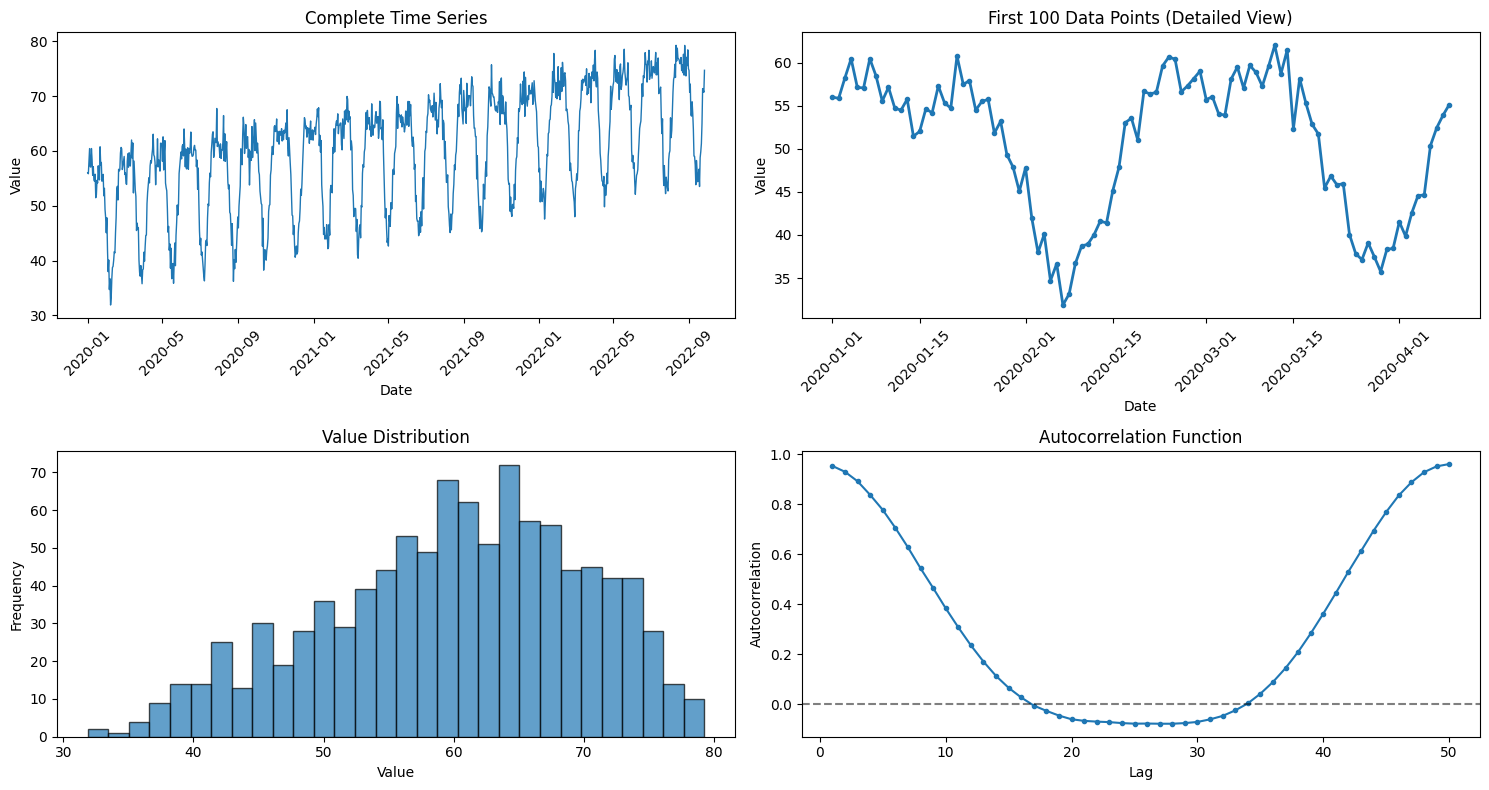

In [2]:
# Visualize the time series data
plt.figure(figsize=(15, 8))

# Plot the full time series
plt.subplot(2, 2, 1)
plt.plot(df['date'], df['value'], linewidth=1)
plt.title('Complete Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)

# Plot a subset to see details
plt.subplot(2, 2, 2)
subset = df.iloc[:100]  # First 100 points
plt.plot(subset['date'], subset['value'], linewidth=2, marker='o', markersize=3)
plt.title('First 100 Data Points (Detailed View)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)

# Plot distribution
plt.subplot(2, 2, 3)
plt.hist(df['value'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Value Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot autocorrelation (simplified version)
plt.subplot(2, 2, 4)
lags = range(1, 51)
autocorr = [df['value'].autocorr(lag=lag) for lag in lags]
plt.plot(lags, autocorr, marker='o', markersize=3)
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## Handling Missing Values and Outliers

In [3]:
def detect_outliers(series, method='iqr', threshold=1.5):
    """
    Detect outliers in time series data using IQR method
    """
    if method == 'iqr':
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = (series < lower_bound) | (series > upper_bound)
    
    return outliers

def handle_missing_values(df, method='interpolation'):
    """
    Handle missing values in time series data
    """
    df_clean = df.copy()
    
    if method == 'interpolation':
        # Linear interpolation for missing values
        df_clean['value'] = df_clean['value'].interpolate(method='linear')
    elif method == 'forward_fill':
        # Forward fill (use previous value)
        df_clean['value'] = df_clean['value'].fillna(method='ffill')
    elif method == 'backward_fill':
        # Backward fill (use next value)
        df_clean['value'] = df_clean['value'].fillna(method='bfill')
    
    return df_clean

# Introduce some missing values and outliers for demonstration
df_with_issues = df.copy()

# Add some missing values
missing_indices = np.random.choice(df.index, size=20, replace=False)
df_with_issues.loc[missing_indices, 'value'] = np.nan

# Add some outliers
outlier_indices = np.random.choice(df.index, size=10, replace=False)
df_with_issues.loc[outlier_indices, 'value'] *= 3  # Make values 3x larger

print(f"Missing values: {df_with_issues['value'].isna().sum()}")

# Detect outliers
outliers = detect_outliers(df_with_issues['value'].dropna())
print(f"Detected outliers: {outliers.sum()}")

# Handle missing values
df_cleaned = handle_missing_values(df_with_issues)
print(f"Missing values after cleaning: {df_cleaned['value'].isna().sum()}")


Missing values: 20
Detected outliers: 11
Missing values after cleaning: 0


## Data Normalization and Scaling

Original data range: 31.879818961385343 to 216.02235062377446
Scaled data range: 0.0 to 1.0000000000000002


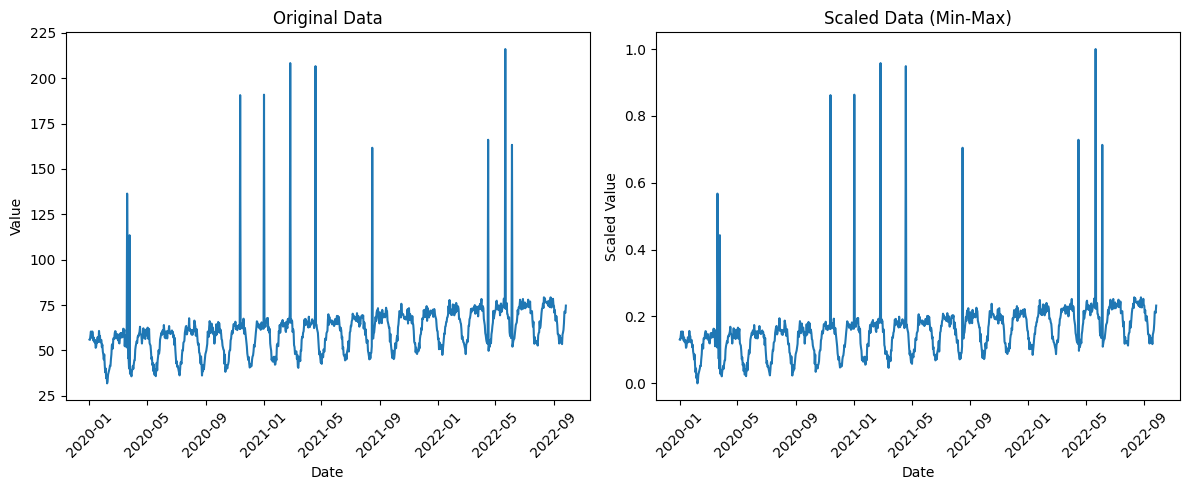

In [4]:
class TimeSeriesScaler:
    """
    Custom scaler for time series data that maintains temporal order
    """
    def __init__(self, method='minmax'):
        self.method = method
        self.scaler = None
        self.fitted = False
    
    def fit(self, data):
        """
        Fit the scaler on training data
        """
        if self.method == 'minmax':
            self.scaler = MinMaxScaler()
        elif self.method == 'standard':
            from sklearn.preprocessing import StandardScaler
            self.scaler = StandardScaler()
        
        # Reshape for sklearn (expects 2D array)
        data_reshaped = data.values.reshape(-1, 1)
        self.scaler.fit(data_reshaped)
        self.fitted = True
        
        return self
    
    def transform(self, data):
        """
        Transform data using fitted scaler
        """
        if not self.fitted:
            raise ValueError("Scaler must be fitted before transform")
        
        data_reshaped = data.values.reshape(-1, 1)
        scaled_data = self.scaler.transform(data_reshaped)
        return scaled_data.flatten()
    
    def inverse_transform(self, data):
        """
        Inverse transform scaled data back to original scale
        """
        if not self.fitted:
            raise ValueError("Scaler must be fitted before inverse_transform")
        
        data_reshaped = data.reshape(-1, 1)
        original_data = self.scaler.inverse_transform(data_reshaped)
        return original_data.flatten()

# Apply scaling to our cleaned data
scaler = TimeSeriesScaler(method='minmax')
scaler.fit(df_cleaned['value'])
scaled_values = scaler.transform(df_cleaned['value'])

print("Original data range:", df_cleaned['value'].min(), "to", df_cleaned['value'].max())
print("Scaled data range:", scaled_values.min(), "to", scaled_values.max())

# Create scaled dataframe
df_scaled = df_cleaned.copy()
df_scaled['value'] = scaled_values

# Visualize the effect of scaling
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(df_cleaned['date'], df_cleaned['value'])
plt.title('Original Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.plot(df_scaled['date'], df_scaled['value'])
plt.title('Scaled Data (Min-Max)')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Feature Engineering for Time Series

In [5]:
def create_time_features(df):
    """
    Create time-based features from datetime index
    """
    df_features = df.copy()
    
    # Extract basic time components
    df_features['year'] = df_features['date'].dt.year
    df_features['month'] = df_features['date'].dt.month
    df_features['day'] = df_features['date'].dt.day
    df_features['dayofweek'] = df_features['date'].dt.dayofweek
    df_features['dayofyear'] = df_features['date'].dt.dayofyear
    df_features['quarter'] = df_features['date'].dt.quarter
    
    # Create cyclical features (important for capturing seasonality)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    df_features['day_sin'] = np.sin(2 * np.pi * df_features['day'] / 31)
    df_features['day_cos'] = np.cos(2 * np.pi * df_features['day'] / 31)
    df_features['dayofweek_sin'] = np.sin(2 * np.pi * df_features['dayofweek'] / 7)
    df_features['dayofweek_cos'] = np.cos(2 * np.pi * df_features['dayofweek'] / 7)
    
    return df_features

def create_lag_features(df, target_col='value', lags=[1, 2, 3, 7, 14, 30]):
    """
    Create lagged features (previous values)
    """
    df_lag = df.copy()
    
    for lag in lags:
        df_lag[f'{target_col}_lag_{lag}'] = df_lag[target_col].shift(lag)
    
    return df_lag

def create_rolling_features(df, target_col='value', windows=[3, 7, 14, 30]):
    """
    Create rolling window features (moving averages, etc.)
    """
    df_rolling = df.copy()
    
    for window in windows:
        # Rolling mean
        df_rolling[f'{target_col}_rolling_mean_{window}'] = df_rolling[target_col].rolling(window=window).mean()
        
        # Rolling standard deviation
        df_rolling[f'{target_col}_rolling_std_{window}'] = df_rolling[target_col].rolling(window=window).std()
        
        # Rolling min and max
        df_rolling[f'{target_col}_rolling_min_{window}'] = df_rolling[target_col].rolling(window=window).min()
        df_rolling[f'{target_col}_rolling_max_{window}'] = df_rolling[target_col].rolling(window=window).max()
    
    return df_rolling

# Apply feature engineering to our data
print("Creating comprehensive feature set...")

# Start with time features
df_with_features = create_time_features(df_scaled)
print(f"After time features: {df_with_features.shape}")

# Add lag features
df_with_features = create_lag_features(df_with_features)
print(f"After lag features: {df_with_features.shape}")

# Add rolling features
df_with_features = create_rolling_features(df_with_features)
print(f"After rolling features: {df_with_features.shape}")

# Display feature names
feature_columns = [col for col in df_with_features.columns if col not in ['date', 'value']]
print(f"\nCreated {len(feature_columns)} features:")
for i, col in enumerate(feature_columns):
    print(f"{i+1:2d}. {col}")


Creating comprehensive feature set...
After time features: (1000, 14)
After lag features: (1000, 20)
After rolling features: (1000, 36)

Created 34 features:
 1. year
 2. month
 3. day
 4. dayofweek
 5. dayofyear
 6. quarter
 7. month_sin
 8. month_cos
 9. day_sin
10. day_cos
11. dayofweek_sin
12. dayofweek_cos
13. value_lag_1
14. value_lag_2
15. value_lag_3
16. value_lag_7
17. value_lag_14
18. value_lag_30
19. value_rolling_mean_3
20. value_rolling_std_3
21. value_rolling_min_3
22. value_rolling_max_3
23. value_rolling_mean_7
24. value_rolling_std_7
25. value_rolling_min_7
26. value_rolling_max_7
27. value_rolling_mean_14
28. value_rolling_std_14
29. value_rolling_min_14
30. value_rolling_max_14
31. value_rolling_mean_30
32. value_rolling_std_30
33. value_rolling_min_30
34. value_rolling_max_30


## Visualization

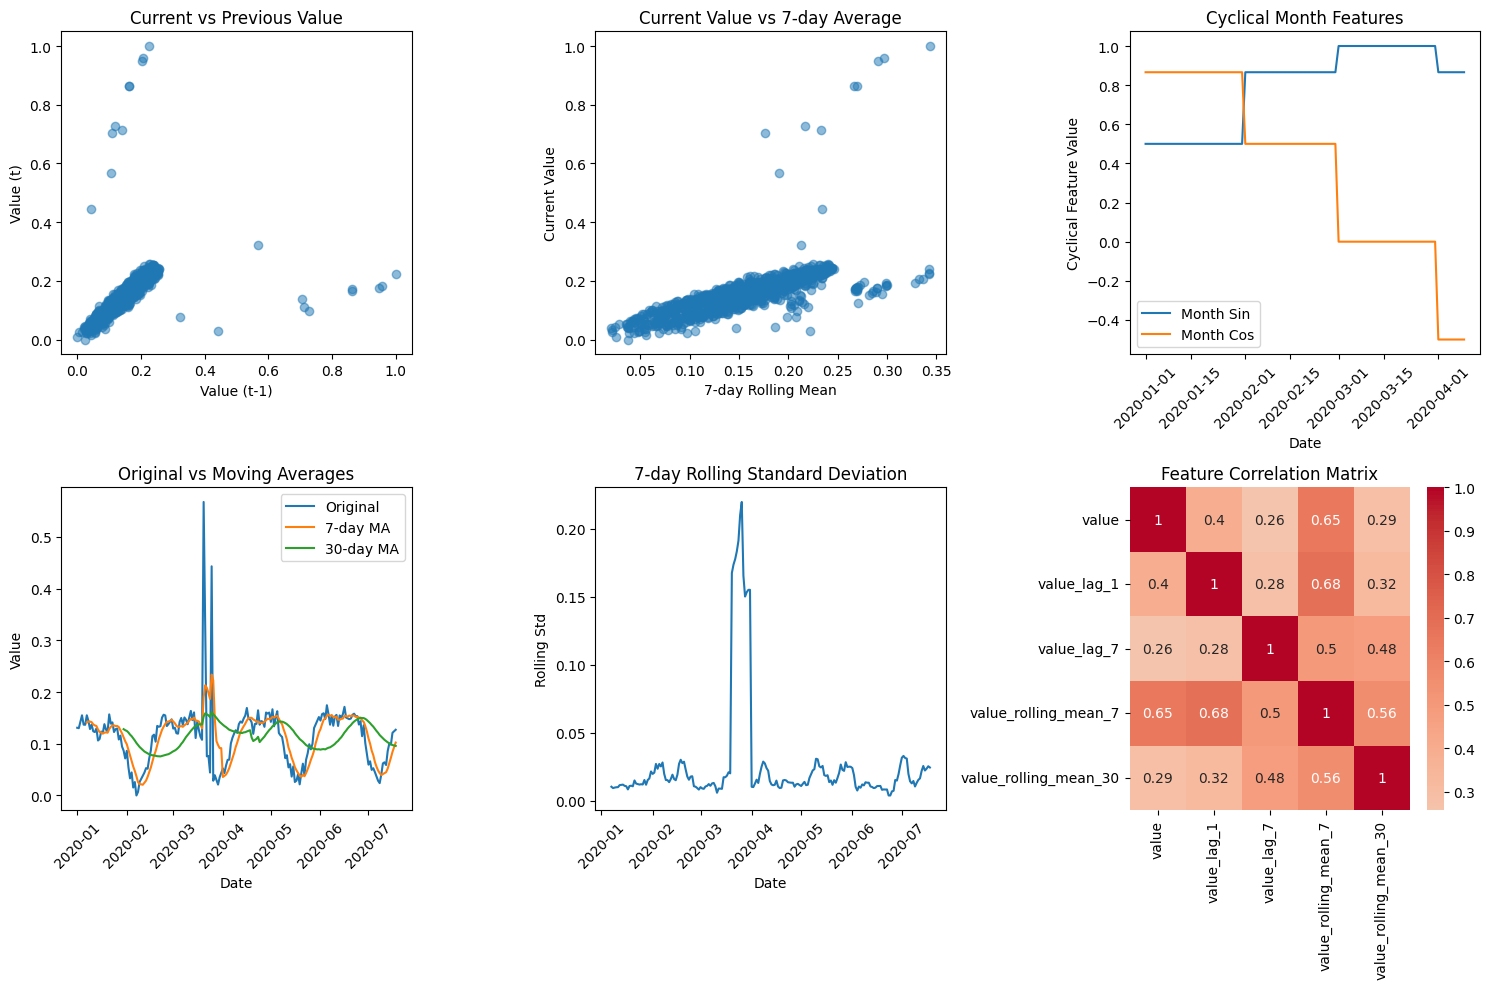

In [6]:
# Visualize feature relationships
plt.figure(figsize=(15, 10))

# Plot original value vs some key features
plt.subplot(2, 3, 1)
plt.scatter(df_with_features['value_lag_1'].dropna(), 
           df_with_features['value'].dropna()[1:], alpha=0.5)
plt.xlabel('Value (t-1)')
plt.ylabel('Value (t)')
plt.title('Current vs Previous Value')

plt.subplot(2, 3, 2)
plt.scatter(df_with_features['value_rolling_mean_7'].dropna(), 
           df_with_features['value'].dropna()[6:], alpha=0.5)
plt.xlabel('7-day Rolling Mean')
plt.ylabel('Current Value')
plt.title('Current Value vs 7-day Average')

plt.subplot(2, 3, 3)
plt.plot(df_with_features['date'][:100], df_with_features['month_sin'][:100], label='Month Sin')
plt.plot(df_with_features['date'][:100], df_with_features['month_cos'][:100], label='Month Cos')
plt.xlabel('Date')
plt.ylabel('Cyclical Feature Value')
plt.title('Cyclical Month Features')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(2, 3, 4)
plt.plot(df_with_features['date'][:200], df_with_features['value'][:200], label='Original')
plt.plot(df_with_features['date'][:200], df_with_features['value_rolling_mean_7'][:200], label='7-day MA')
plt.plot(df_with_features['date'][:200], df_with_features['value_rolling_mean_30'][:200], label='30-day MA')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original vs Moving Averages')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(2, 3, 5)
plt.plot(df_with_features['date'][:200], df_with_features['value_rolling_std_7'][:200])
plt.xlabel('Date')
plt.ylabel('Rolling Std')
plt.title('7-day Rolling Standard Deviation')
plt.xticks(rotation=45)

plt.subplot(2, 3, 6)
correlation_features = ['value', 'value_lag_1', 'value_lag_7', 'value_rolling_mean_7', 'value_rolling_mean_30']
corr_matrix = df_with_features[correlation_features].corr()
import seaborn as sns
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()


## Creatung sequences for neural networks

In [7]:
def create_sequences(data, sequence_length, target_col='value', feature_cols=None):
    """
    Create sequences for time series prediction
    
    Args:
        data: DataFrame with time series data
        sequence_length: Number of time steps to look back
        target_col: Name of target column
        feature_cols: List of feature column names (if None, use all except date and target)
    
    Returns:
        X: Input sequences (features)
        y: Target values
    """
    if feature_cols is None:
        feature_cols = [col for col in data.columns if col not in ['date', target_col]]
    
    # Remove rows with NaN values (from lag and rolling features)
    data_clean = data.dropna()
    
    X, y = [], []
    
    for i in range(sequence_length, len(data_clean)):
        # Get sequence of features
        sequence_features = data_clean[feature_cols].iloc[i-sequence_length:i].values
        X.append(sequence_features)
        
        # Get target value
        target_value = data_clean[target_col].iloc[i]
        y.append(target_value)
    
    return np.array(X), np.array(y)

# Create sequences for our model
sequence_length = 30  # Use 30 time steps to predict the next value
print(f"Creating sequences with length {sequence_length}...")

# Select important features (to keep the example manageable)
selected_features = [
    'value_lag_1', 'value_lag_2', 'value_lag_7',
    'value_rolling_mean_7', 'value_rolling_mean_30',
    'value_rolling_std_7',
    'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos'
]

X, y = create_sequences(df_with_features, sequence_length, 
                       target_col='value', feature_cols=selected_features)

print(f"Input sequences shape: {X.shape}")
print(f"Target values shape: {y.shape}")
print(f"Each sequence contains {X.shape[1]} time steps with {X.shape[2]} features")


Creating sequences with length 30...
Input sequences shape: (940, 30, 10)
Target values shape: (940,)
Each sequence contains 30 time steps with 10 features


## Split

In [8]:
def train_test_split_temporal(X, y, test_size=0.2):
    """
    Split time series data maintaining temporal order
    """
    split_idx = int(len(X) * (1 - test_size))
    
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = train_test_split_temporal(X, y, test_size=0.2)

print("Training set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print("\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

print(f"\nPyTorch tensors created successfully")
print(f"Training data device: {X_train_tensor.device}")


Training set:
  X_train shape: (752, 30, 10)
  y_train shape: (752,)

Test set:
  X_test shape: (188, 30, 10)
  y_test shape: (188,)

PyTorch tensors created successfully
Training data device: cpu


## LSTM Time Series Model

In [9]:
class LSTMTimeSeriesModel(nn.Module):
    """
    LSTM model for time series prediction
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMTimeSeriesModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Output layer
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Take the output from the last time step
        last_output = lstm_out[:, -1, :]
        
        # Apply dropout
        dropped = self.dropout(last_output)
        
        # Linear layer for final prediction
        output = self.linear(dropped)
        
        return output

# Model parameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 64
num_layers = 2
output_size = 1
dropout = 0.2

# Create the model
model = LSTMTimeSeriesModel(input_size, hidden_size, num_layers, output_size, dropout)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model Architecture:
LSTMTimeSeriesModel(
  (lstm): LSTM(10, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

Total parameters: 52,801
Trainable parameters: 52,801


## Training loop

In [11]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                      factor=0.5, patience=10)

def train_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    """
    Train the LSTM model
    """
    train_losses = []
    test_losses = []
    
    # Create data loaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs.squeeze(), y_test).item()
        
        # Update learning rate
        scheduler.step(test_loss)
        
        # Record losses
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        test_losses.append(test_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {test_loss:.6f}')
    
    return train_losses, test_losses

print("Starting model training...")
train_losses, test_losses = train_model(model, X_train_tensor, y_train_tensor, 
                                       X_test_tensor, y_test_tensor, epochs=100, batch_size=32)


Using device: cpu
Starting model training...
Epoch [10/100], Train Loss: 0.006960, Test Loss: 0.009116
Epoch [20/100], Train Loss: 0.005638, Test Loss: 0.008317
Epoch [30/100], Train Loss: 0.005269, Test Loss: 0.007962
Epoch [40/100], Train Loss: 0.005053, Test Loss: 0.007737
Epoch [50/100], Train Loss: 0.004610, Test Loss: 0.008141
Epoch [60/100], Train Loss: 0.004650, Test Loss: 0.008162
Epoch [70/100], Train Loss: 0.004570, Test Loss: 0.008272
Epoch [80/100], Train Loss: 0.004628, Test Loss: 0.008461
Epoch [90/100], Train Loss: 0.004543, Test Loss: 0.008527
Epoch [100/100], Train Loss: 0.004596, Test Loss: 0.008567


## Visualize


Model Performance:
Training MSE: 147.5354
Test MSE: 290.4995
Training MAE: 4.7529
Test MAE: 7.4213


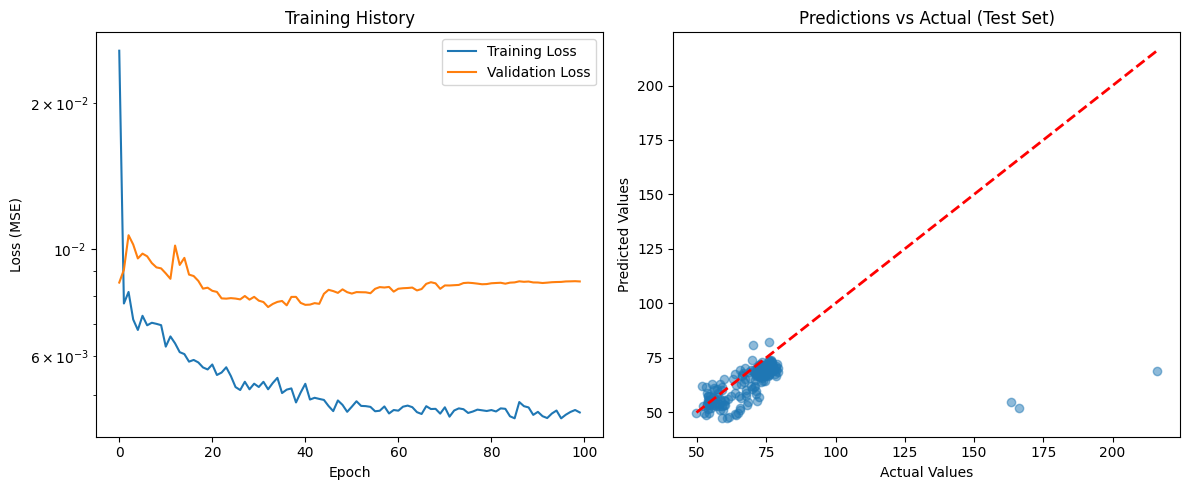

In [12]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training History')
plt.legend()
plt.yscale('log')

# Make predictions
model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor).cpu().numpy().squeeze()
    test_predictions = model(X_test_tensor).cpu().numpy().squeeze()

# Convert back to original scale
train_predictions_original = scaler.inverse_transform(train_predictions)
test_predictions_original = scaler.inverse_transform(test_predictions)
y_train_original = scaler.inverse_transform(y_train)
y_test_original = scaler.inverse_transform(y_test)

# Calculate metrics
train_mse = mean_squared_error(y_train_original, train_predictions_original)
test_mse = mean_squared_error(y_test_original, test_predictions_original)
train_mae = mean_absolute_error(y_train_original, train_predictions_original)
test_mae = mean_absolute_error(y_test_original, test_predictions_original)

print(f"\nModel Performance:")
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Plot predictions vs actual values
plt.subplot(1, 2, 2)
plt.scatter(y_test_original, test_predictions_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual (Test Set)')

plt.tight_layout()
plt.show()


## GRU with Attention

In [13]:
class AttentionLayer(nn.Module):
    """
    Attention mechanism for sequence data
    """
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Linear(hidden_size, 1, bias=False)
        
    def forward(self, gru_output):
        # gru_output shape: (batch_size, seq_len, hidden_size)
        
        # Calculate attention scores
        attention_scores = self.attention(gru_output)  # (batch_size, seq_len, 1)
        attention_weights = torch.softmax(attention_scores, dim=1)  # Normalize across sequence
        
        # Apply attention weights
        context_vector = torch.sum(attention_weights * gru_output, dim=1)  # (batch_size, hidden_size)
        
        return context_vector, attention_weights

class GRUWithAttention(nn.Module):
    """
    GRU model with attention mechanism for time series prediction
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(GRUWithAttention, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, 
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Attention layer
        self.attention = AttentionLayer(hidden_size)
        
        # Output layers
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
    def forward(self, x):
        # Initialize hidden state
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # GRU forward pass
        gru_output, _ = self.gru(x, h0)  # (batch_size, seq_len, hidden_size)
        
        # Apply attention
        context_vector, attention_weights = self.attention(gru_output)
        
        # Final prediction layers
        output = self.fc1(context_vector)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        
        return output, attention_weights

# Create the advanced model
advanced_model = GRUWithAttention(input_size, hidden_size=64, num_layers=2, 
                                 output_size=1, dropout=0.3)
advanced_model = advanced_model.to(device)

print("Advanced Model Architecture:")
print(advanced_model)
print(f"\nTotal parameters: {sum(p.numel() for p in advanced_model.parameters()):,}")


Advanced Model Architecture:
GRUWithAttention(
  (gru): GRU(10, 64, num_layers=2, batch_first=True, dropout=0.3)
  (attention): AttentionLayer(
    (attention): Linear(in_features=64, out_features=1, bias=False)
  )
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 41,729


## Training advanced model

In [15]:
def train_advanced_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    """
    Train the GRU model with attention
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                          factor=0.5, patience=10)
    
    train_losses = []
    test_losses = []
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            
            # Forward pass (note: advanced model returns predictions and attention weights)
            outputs, _ = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            test_outputs, _ = model(X_test)
            test_loss = criterion(test_outputs.squeeze(), y_test).item()
        
        scheduler.step(test_loss)
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        test_losses.append(test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {test_loss:.6f}')
    
    return train_losses, test_losses

print("Training advanced model...")
advanced_train_losses, advanced_test_losses = train_advanced_model(
    advanced_model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=100)


Training advanced model...
Epoch [10/100], Train Loss: 0.007553, Test Loss: 0.011929
Epoch [20/100], Train Loss: 0.006887, Test Loss: 0.012739
Epoch [30/100], Train Loss: 0.006760, Test Loss: 0.013091
Epoch [40/100], Train Loss: 0.006440, Test Loss: 0.013425
Epoch [50/100], Train Loss: 0.006457, Test Loss: 0.014065
Epoch [60/100], Train Loss: 0.006480, Test Loss: 0.014414
Epoch [70/100], Train Loss: 0.006376, Test Loss: 0.014550
Epoch [80/100], Train Loss: 0.006470, Test Loss: 0.014678
Epoch [90/100], Train Loss: 0.006456, Test Loss: 0.014744
Epoch [100/100], Train Loss: 0.006476, Test Loss: 0.014792


Model Comparison:
Basic LSTM Model:
  Training MSE: 147.5354, MAE: 4.7529
  Test MSE: 290.4995, MAE: 7.4213

Advanced GRU + Attention Model:
  Training MSE: 204.4590, MAE: 8.1417
  Test MSE: 501.5878, MAE: 15.3331


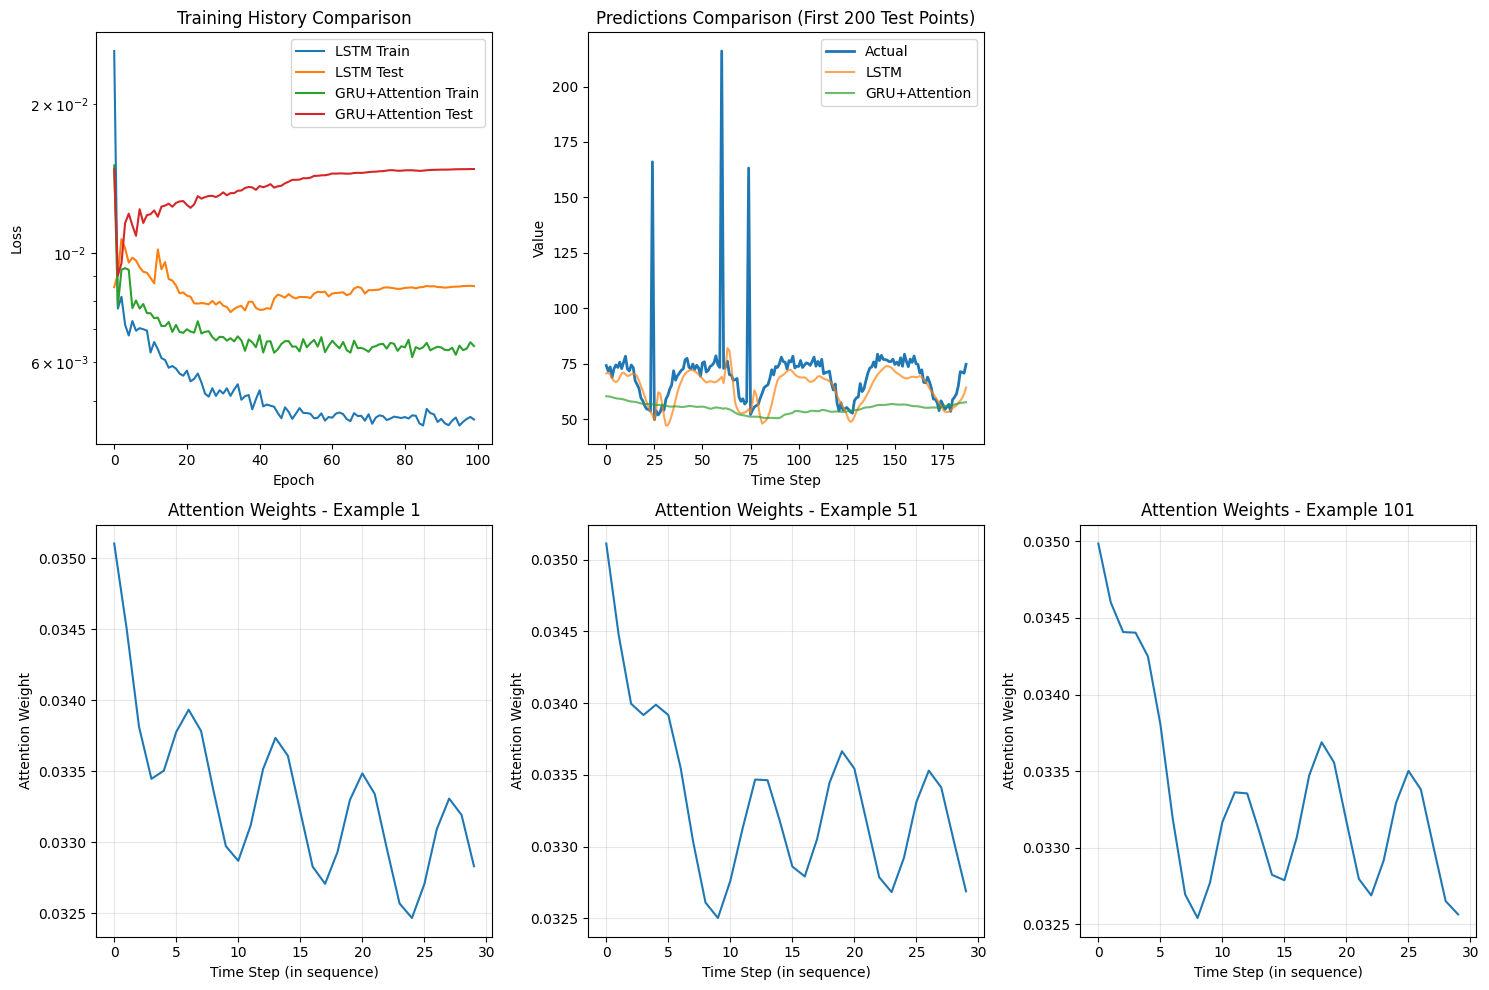

In [16]:
# Evaluate advanced model
advanced_model.eval()
with torch.no_grad():
    advanced_train_pred, _ = advanced_model(X_train_tensor)
    advanced_test_pred, test_attention = advanced_model(X_test_tensor)
    
    advanced_train_pred = advanced_train_pred.cpu().numpy().squeeze()
    advanced_test_pred = advanced_test_pred.cpu().numpy().squeeze()
    test_attention = test_attention.cpu().numpy()

# Convert to original scale
advanced_train_pred_orig = scaler.inverse_transform(advanced_train_pred)
advanced_test_pred_orig = scaler.inverse_transform(advanced_test_pred)

# Calculate metrics for advanced model
advanced_train_mse = mean_squared_error(y_train_original, advanced_train_pred_orig)
advanced_test_mse = mean_squared_error(y_test_original, advanced_test_pred_orig)
advanced_train_mae = mean_absolute_error(y_train_original, advanced_train_pred_orig)
advanced_test_mae = mean_absolute_error(y_test_original, advanced_test_pred_orig)

print("Model Comparison:")
print("="*50)
print("Basic LSTM Model:")
print(f"  Training MSE: {train_mse:.4f}, MAE: {train_mae:.4f}")
print(f"  Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}")
print("\nAdvanced GRU + Attention Model:")
print(f"  Training MSE: {advanced_train_mse:.4f}, MAE: {advanced_train_mae:.4f}")
print(f"  Test MSE: {advanced_test_mse:.4f}, MAE: {advanced_test_mae:.4f}")

# Visualize attention weights for a few examples
plt.figure(figsize=(15, 10))

# Plot training histories comparison
plt.subplot(2, 3, 1)
plt.plot(train_losses, label='LSTM Train')
plt.plot(test_losses, label='LSTM Test')
plt.plot(advanced_train_losses, label='GRU+Attention Train')
plt.plot(advanced_test_losses, label='GRU+Attention Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History Comparison')
plt.legend()
plt.yscale('log')

# Plot predictions comparison
plt.subplot(2, 3, 2)
sample_indices = range(0, min(200, len(y_test_original)))
plt.plot(sample_indices, y_test_original[sample_indices], label='Actual', linewidth=2)
plt.plot(sample_indices, test_predictions_original[sample_indices], label='LSTM', alpha=0.7)
plt.plot(sample_indices, advanced_test_pred_orig[sample_indices], label='GRU+Attention', alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Predictions Comparison (First 200 Test Points)')
plt.legend()

# Visualize attention weights for a few examples
for i, example_idx in enumerate([0, 50, 100]):
    if example_idx < len(test_attention):
        plt.subplot(2, 3, 4 + i)
        attention_weights = test_attention[example_idx].squeeze()
        plt.plot(range(len(attention_weights)), attention_weights)
        plt.xlabel('Time Step (in sequence)')
        plt.ylabel('Attention Weight')
        plt.title(f'Attention Weights - Example {example_idx + 1}')
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
